# Structural Protein Sequences - Protein Family Classification

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1.) Import Necessary Packages and Libraries

In [3]:
#Data Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.feature_selection import SelectKBest,chi2

#Model Building
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

#Data Analysis and Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import numpy as np
import pandas as pd
import seaborn as sns

# 2.) Data Preprocessing and Cleaning

In [14]:
# load data into a pandas dataframe
df = pd.read_csv ("LINK_TO_DATASET/pdb_data_no_dups.csv")

# filter for protein macromoleculeType_x
df = df[df['macromoleculeType'] == 'Protein']

# drop irrelevant columns
df.drop(['experimentalTechnique', 
         'crystallizationMethod', 
         'pdbxDetails', 
         'publicationYear', 
         'structureId'], axis=1, inplace=True)

# drop rows with missing values
df.dropna(inplace=True)

# determine the top 5 classifications
top_5 = df['classification'].value_counts().nlargest(5).index.tolist()

# filter the dataset to keep only rows with top 5 classifications
df = df[df['classification'].isin(top_5)]

# encode categorical variable
encoder = LabelEncoder()
df['classification'] = encoder.fit_transform(df['classification'])
df['macromoleculeType'] = encoder.fit_transform(df['macromoleculeType'])

# standardize numerical variables
scaler = StandardScaler()
df[['residueCount', 
    'resolution', 
    'structureMolecularWeight', 
    'crystallizationTempK', 
    'densityMatthews', 
    'densityPercentSol']] = scaler.fit_transform(df[['residueCount', 
                                                     'resolution', 
                                                     'structureMolecularWeight', 
                                                     'crystallizationTempK', 
                                                     'densityMatthews', 
                                                     'densityPercentSol']])

# 3.) Exploratory Data Analysis

Summary statistics of the numerical variables:
       classification  macromoleculeType  residueCount    resolution  \
count    37769.000000            37769.0  3.776900e+04  3.776900e+04   
mean         1.978845                0.0 -3.085308e-17  2.197342e-16   
std          1.672542                0.0  1.000013e+00  1.000013e+00   
min          0.000000                0.0 -8.109177e-01 -2.798447e+00   
25%          0.000000                0.0 -4.910586e-01 -6.415190e-01   
50%          2.000000                0.0 -2.781723e-01 -1.316998e-01   
75%          4.000000                0.0  1.285360e-01  6.134207e-01   
max          4.000000                0.0  6.038173e+01  1.361381e+01   

       structureMolecularWeight  crystallizationTempK  densityMatthews  \
count              3.776900e+04          3.776900e+04     3.776900e+04   
mean               3.235811e-17          3.517251e-15    -2.686476e-16   
std                1.000013e+00          1.000013e+00     1.000013e+00   
min     

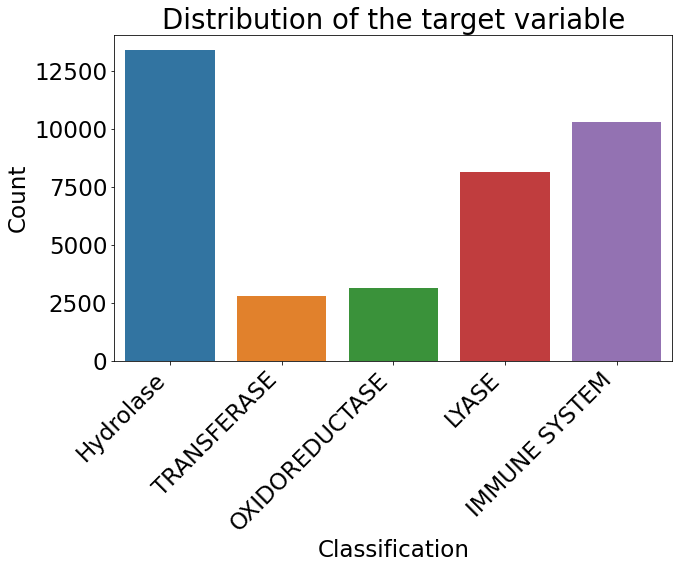

In [10]:
#Check the summary statistics of the numerical variables
print("Summary statistics of the numerical variables:")
print(df.describe())

#Check distribution of the target variable
plt.figure(figsize=(10,6))
sns.countplot(df['classification'])
plt.title('Distribution of the target variable')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels by 45 degrees and align them to the right
plt.gca().set_xticklabels(["Hydrolase","TRANSFERASE","OXIDOREDUCTASE","LYASE","IMMUNE SYSTEM"])
plt.show()

<Figure size 1440x1440 with 0 Axes>

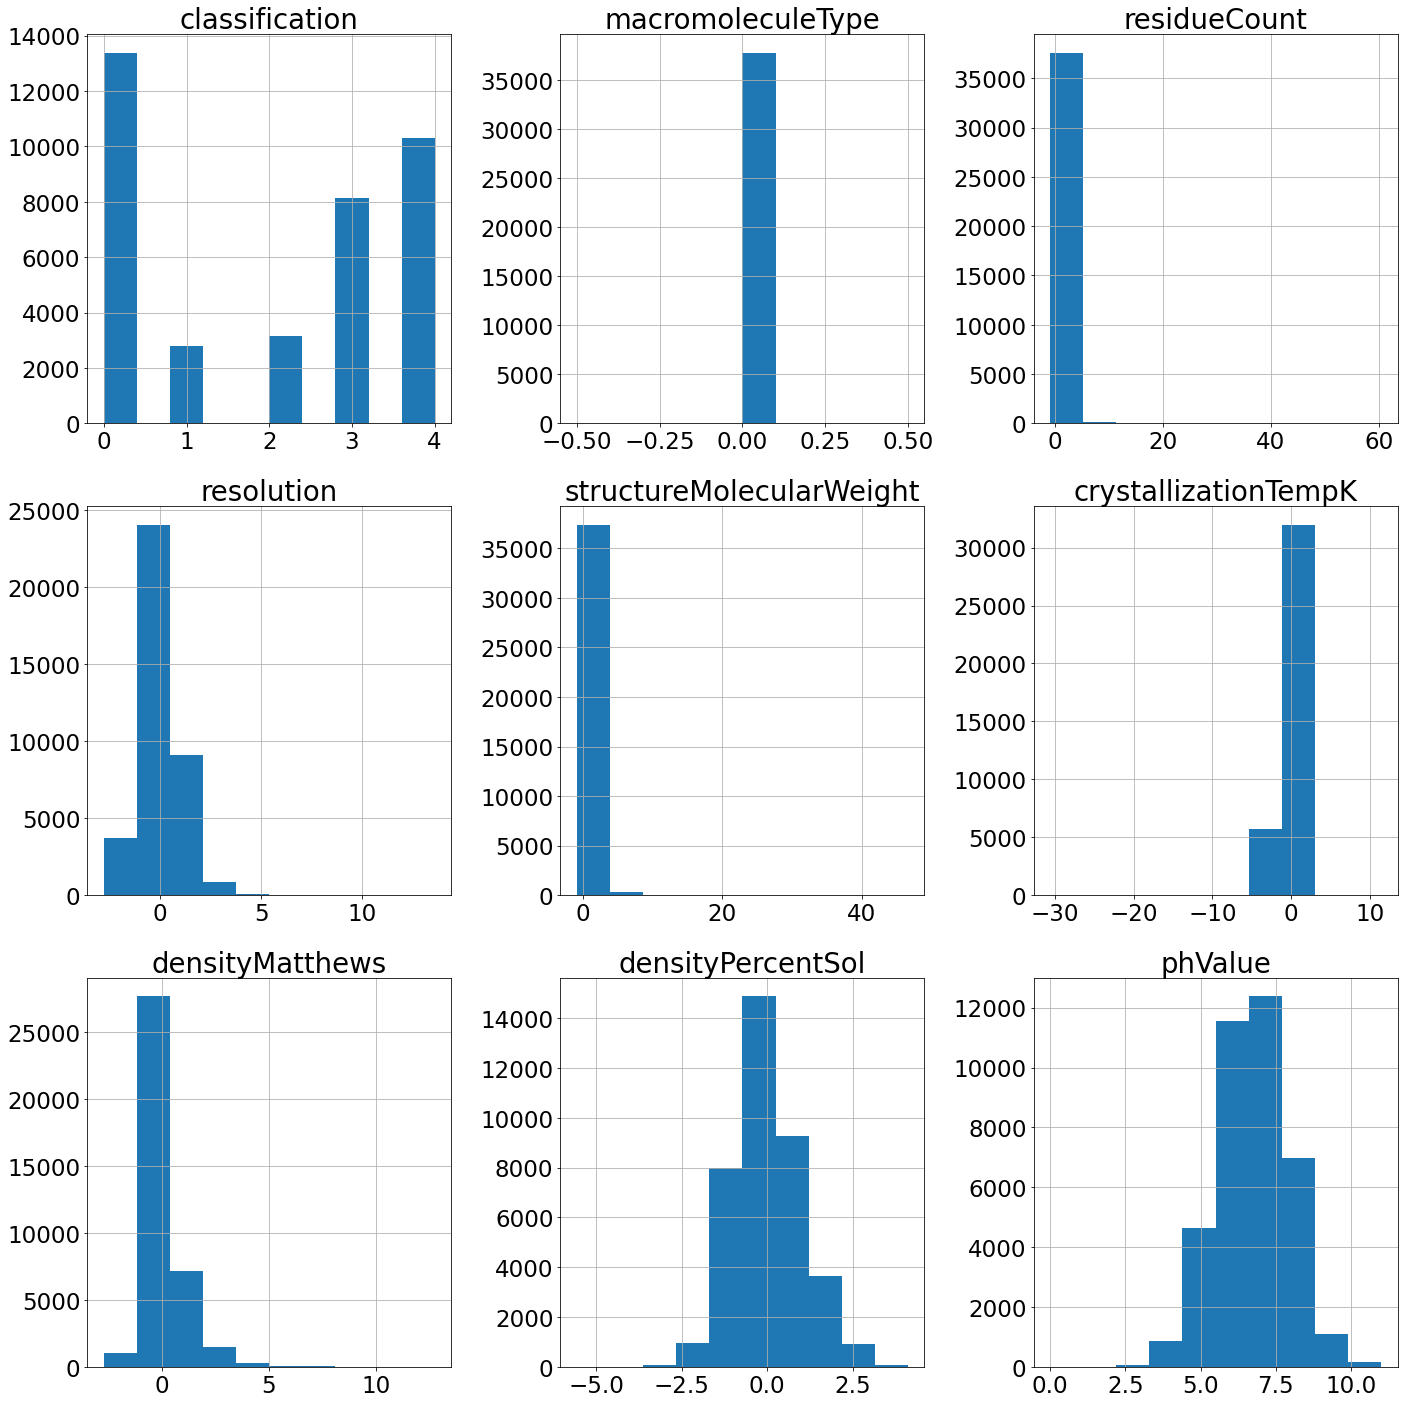

In [9]:
#Check the distribution of the numerical variables
plt.figure(figsize=(20,20))
df.hist(bins=10, figsize=(20,20))
plt.tight_layout()
plt.show()

<Figure size 1440x720 with 0 Axes>

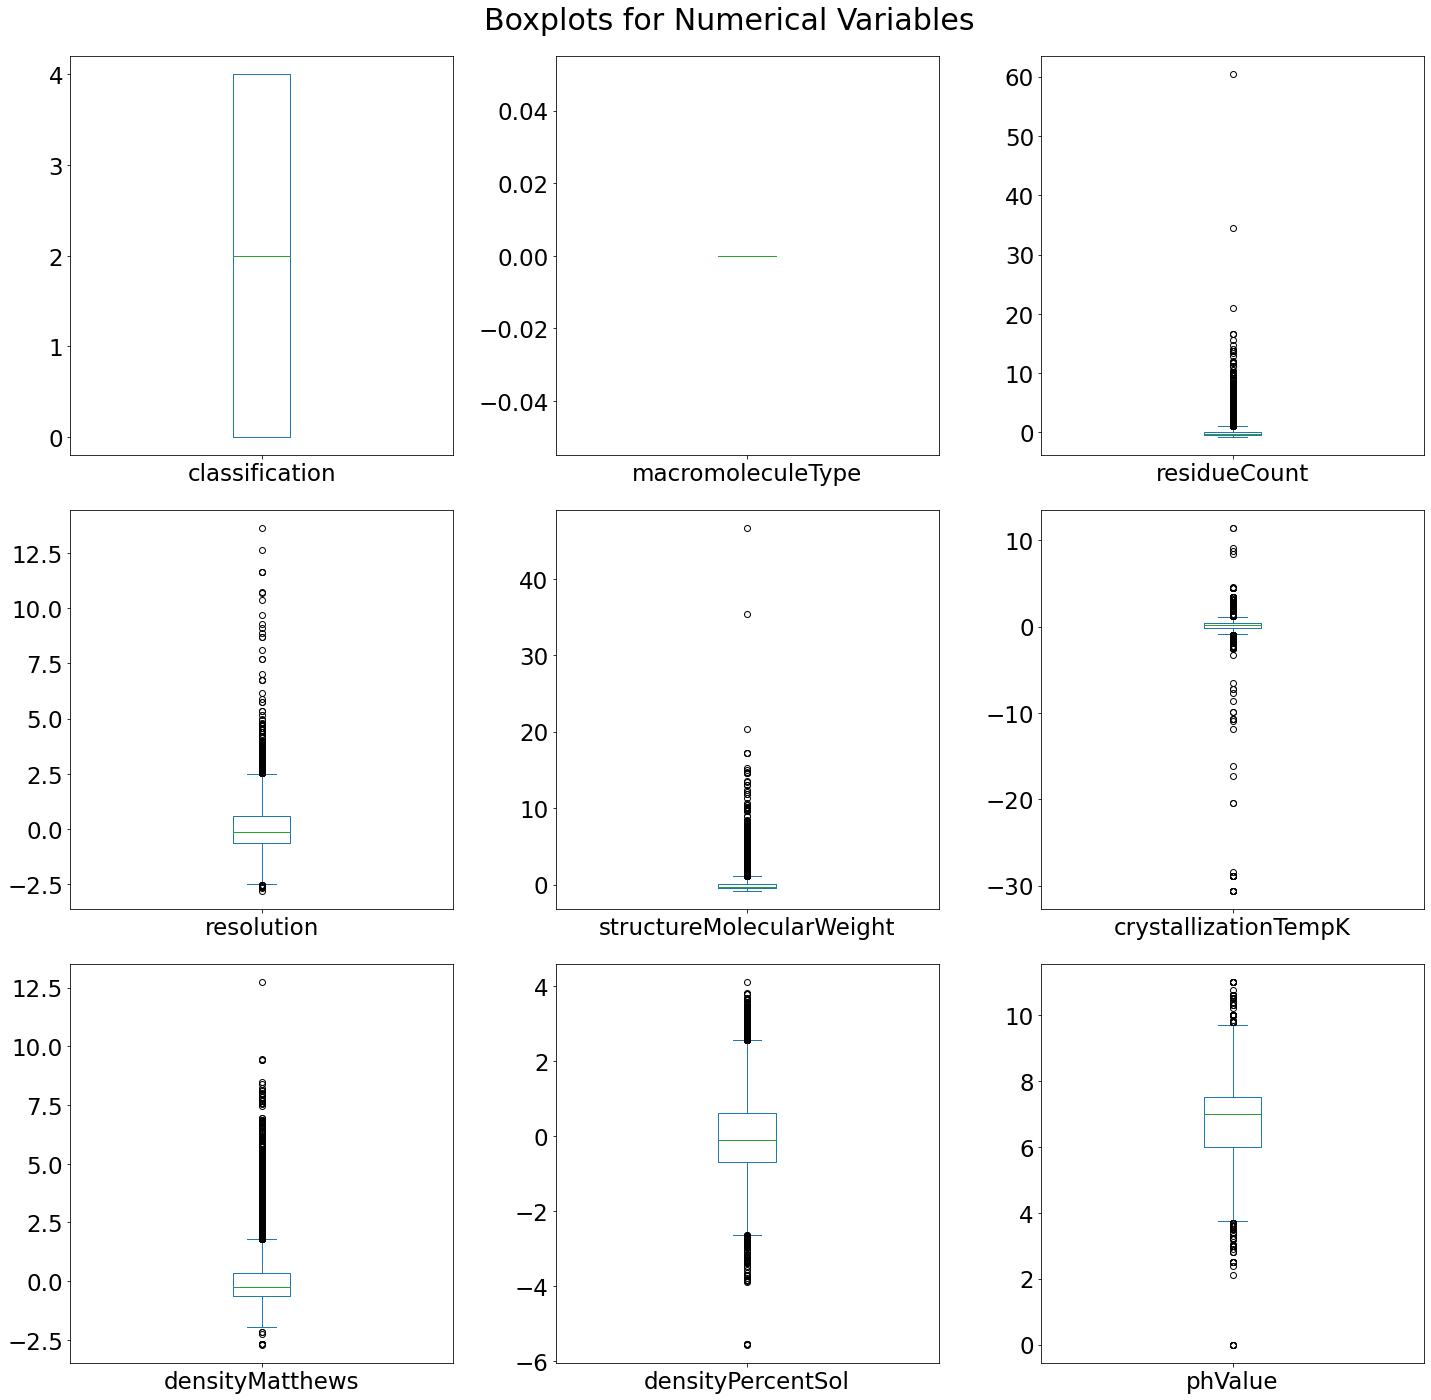

In [8]:
# Set font size for all plots
mpl.rcParams['font.size'] = 23

#Check for outliers in the numerical variables
plt.figure(figsize=(20,10))
df.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20, 20)) # Set figsize in df.plot() function
plt.suptitle('Boxplots for Numerical Variables', fontsize=30) # Add title with larger font size
plt.tight_layout()
plt.show()

# 4.) Model Building

In [11]:
# split data into training and test sets
X = df.drop(['classification'], axis=1)
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# define KNN model and hyperparameters
knn = KNeighborsClassifier()
params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}

# perform grid search to find optimal hyperparameters
grid_search = GridSearchCV(knn, params, cv=5)
grid_search.fit(X_train, y_train)

# print best hyperparameters
print(grid_search.best_params_)

# train KNN model with best hyperparameters
knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], weights=grid_search.best_params_['weights'])
knn.fit(X_train, y_train)

# make predictions on test data
y_pred = knn.predict(X_test)

{'n_neighbors': 11, 'weights': 'distance'}


In [12]:
# evaluate model performance
print(classification_report(y_test, y_pred, target_names=["Hydrolase",
                                                          "TRANSFERASE",
                                                          "OXIDOREDUCTASE",
                                                          "LYASE",
                                                          "IMMUNE SYSTEM"]))

                precision    recall  f1-score   support

     Hydrolase       0.53      0.61      0.57      4068
   TRANSFERASE       0.31      0.17      0.22       811
OXIDOREDUCTASE       0.46      0.28      0.35       893
         LYASE       0.50      0.43      0.46      2457
 IMMUNE SYSTEM       0.44      0.50      0.47      3102

      accuracy                           0.48     11331
     macro avg       0.45      0.40      0.41     11331
  weighted avg       0.48      0.48      0.47     11331



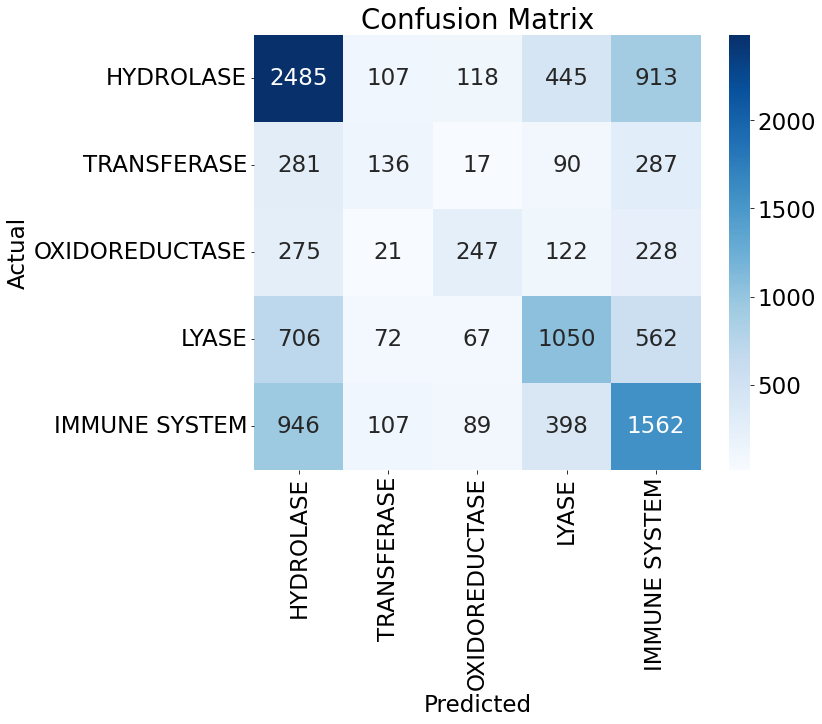

In [13]:
# generate confusion matrix heatmap using Seaborn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=top_5, yticklabels=top_5)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()